In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import pickle
from matplotlib.markers import MarkerStyle
from matplotlib.legend_handler import HandlerTuple
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_lig_test = pd.read_csv(data_dir / "ligand_test_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.ORBITALS
    is_nn: bool = False
    prediction = np.zeros(len(df_lig_test))
    uncertainty = np.zeros(len(df_lig_test))

In [5]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]
experiments = krr_experiments + nn_experiments

In [6]:
for experiment in krr_experiments + nn_experiments:
    x, _ = data_prep(
        df_lig_test, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        experiment.prediction, experiment.uncertainty = model.predict(x, verbose=0)
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        y_mean, y_std = model.predict(x, return_std=True)
        experiment.prediction = y_mean.reshape(-1, 4)
        experiment.uncertainty = y_std.reshape(-1, 4)

2024-04-01 14:24:49.206692: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
test_ligands = [
    "4H-pyran",
    "[OH]-[CH]=[CH]-[OH]",
    "bifuran",
    "pyridine-N-oxide",
    "acrylamide",
    "dmf",
    "thiophene",
    "thiane",
    "4H-thiopyran",
    "oxazoline",
    "thioazole",
    "[NH]=[CH]-[OH]",
    "[PH]=[CH]-[OH]",
    "[NH2]-[NH]-[NH]-[NH2]",
    "1H-tetrazole",
    "1H-triazole",
    "thioformaldehyde",
    "[NH2]-[O]-[O]-[NH2]",
    "bipyrimidine",
    "[PH2]-[CH2]-[OH]",
    "[PH2]-[NH]-[NH]-[PH2]",
]

In [8]:
ligand_names = {name: name for name in test_ligands}
ligand_names["[OH]-[CH]=[CH]-[OH]"] = "ethenediol"
ligand_names["[NH]=[CH]-[OH]"] = "NHCHOH"  # "??formamide??"
ligand_names["[PH]=[CH]-[OH]"] = "PHCHOH"  # "??phosphoral??"
ligand_names["[NH2]-[NH]-[NH]-[NH2]"] = "tetrazane"
ligand_names["[NH2]-[O]-[O]-[NH2]"] = "aminoperoxide"
ligand_names["[PH2]-[CH2]-[OH]"] = "hydroxymethylphosphine"
ligand_names["[PH2]-[NH]-[NH]-[PH2]"] = "bis(phosphanyl)hydrazine"
ligand_names["dmf"] = "dimethylformamide"

In [9]:
model_names = {
    "krr_standard_racs": "KRR standard-RACs",
    "krr_two_body": "KRR two-body",
    "krr_three_body": "KRR three-body",
    "nn_standard_racs": "NN standard-RACs",
    "nn_two_body": "NN two-body",
    "nn_three_body": "NN three-body",
}

In [10]:
def core_legend(ax, scatter_kwargs=None, legend_kwargs=None):
    if scatter_kwargs is None:
        scatter_kwargs = dict(alpha=0.5, edgecolors="none", s=20)
    if legend_kwargs is None:
        legend_kwargs = dict(loc="upper left")

    handles = []
    labels = []
    for metal, color in color_dict.items():
        handles.append(
            (
                ax.scatter(
                    [], [], color=color, marker=marker_dict["2"], **scatter_kwargs
                ),
                ax.scatter(
                    [], [], color=color, marker=marker_dict["3"], **scatter_kwargs
                ),
            )
        )
        labels.append(metal.capitalize())
    for ox, marker in [("II", "o"), ("III", "d")]:
        handles.append(
            ax.scatter(
                [],
                [],
                color="none",
                marker=marker,
                linewidth=0.5,
                **dict(scatter_kwargs, edgecolors="k", alpha=1.0),
            )
        )
        labels.append(ox)

    for spin, fillstyle in [("LS", "left"), ("HS", "right")]:
        handles.append(
            (
                ax.scatter(
                    [],
                    [],
                    color="none",
                    marker=MarkerStyle("o", fillstyle=fillstyle),
                    linewidth=0.5,
                    **dict(scatter_kwargs, edgecolors="k", alpha=1.0),
                ),
                ax.scatter(
                    [],
                    [],
                    color="none",
                    marker=MarkerStyle("d", fillstyle=fillstyle),
                    linewidth=0.5,
                    **dict(scatter_kwargs, edgecolors="k", alpha=1.0),
                ),
            )
        )
        labels.append(spin)

    kwargs = {
        "ncols": 8,
        "handler_map": {tuple: HandlerTuple(ndivide=None, pad=-0.1)},
    }
    kwargs.update(legend_kwargs)

    legend = ax.legend(handles, labels, **kwargs)
    return legend

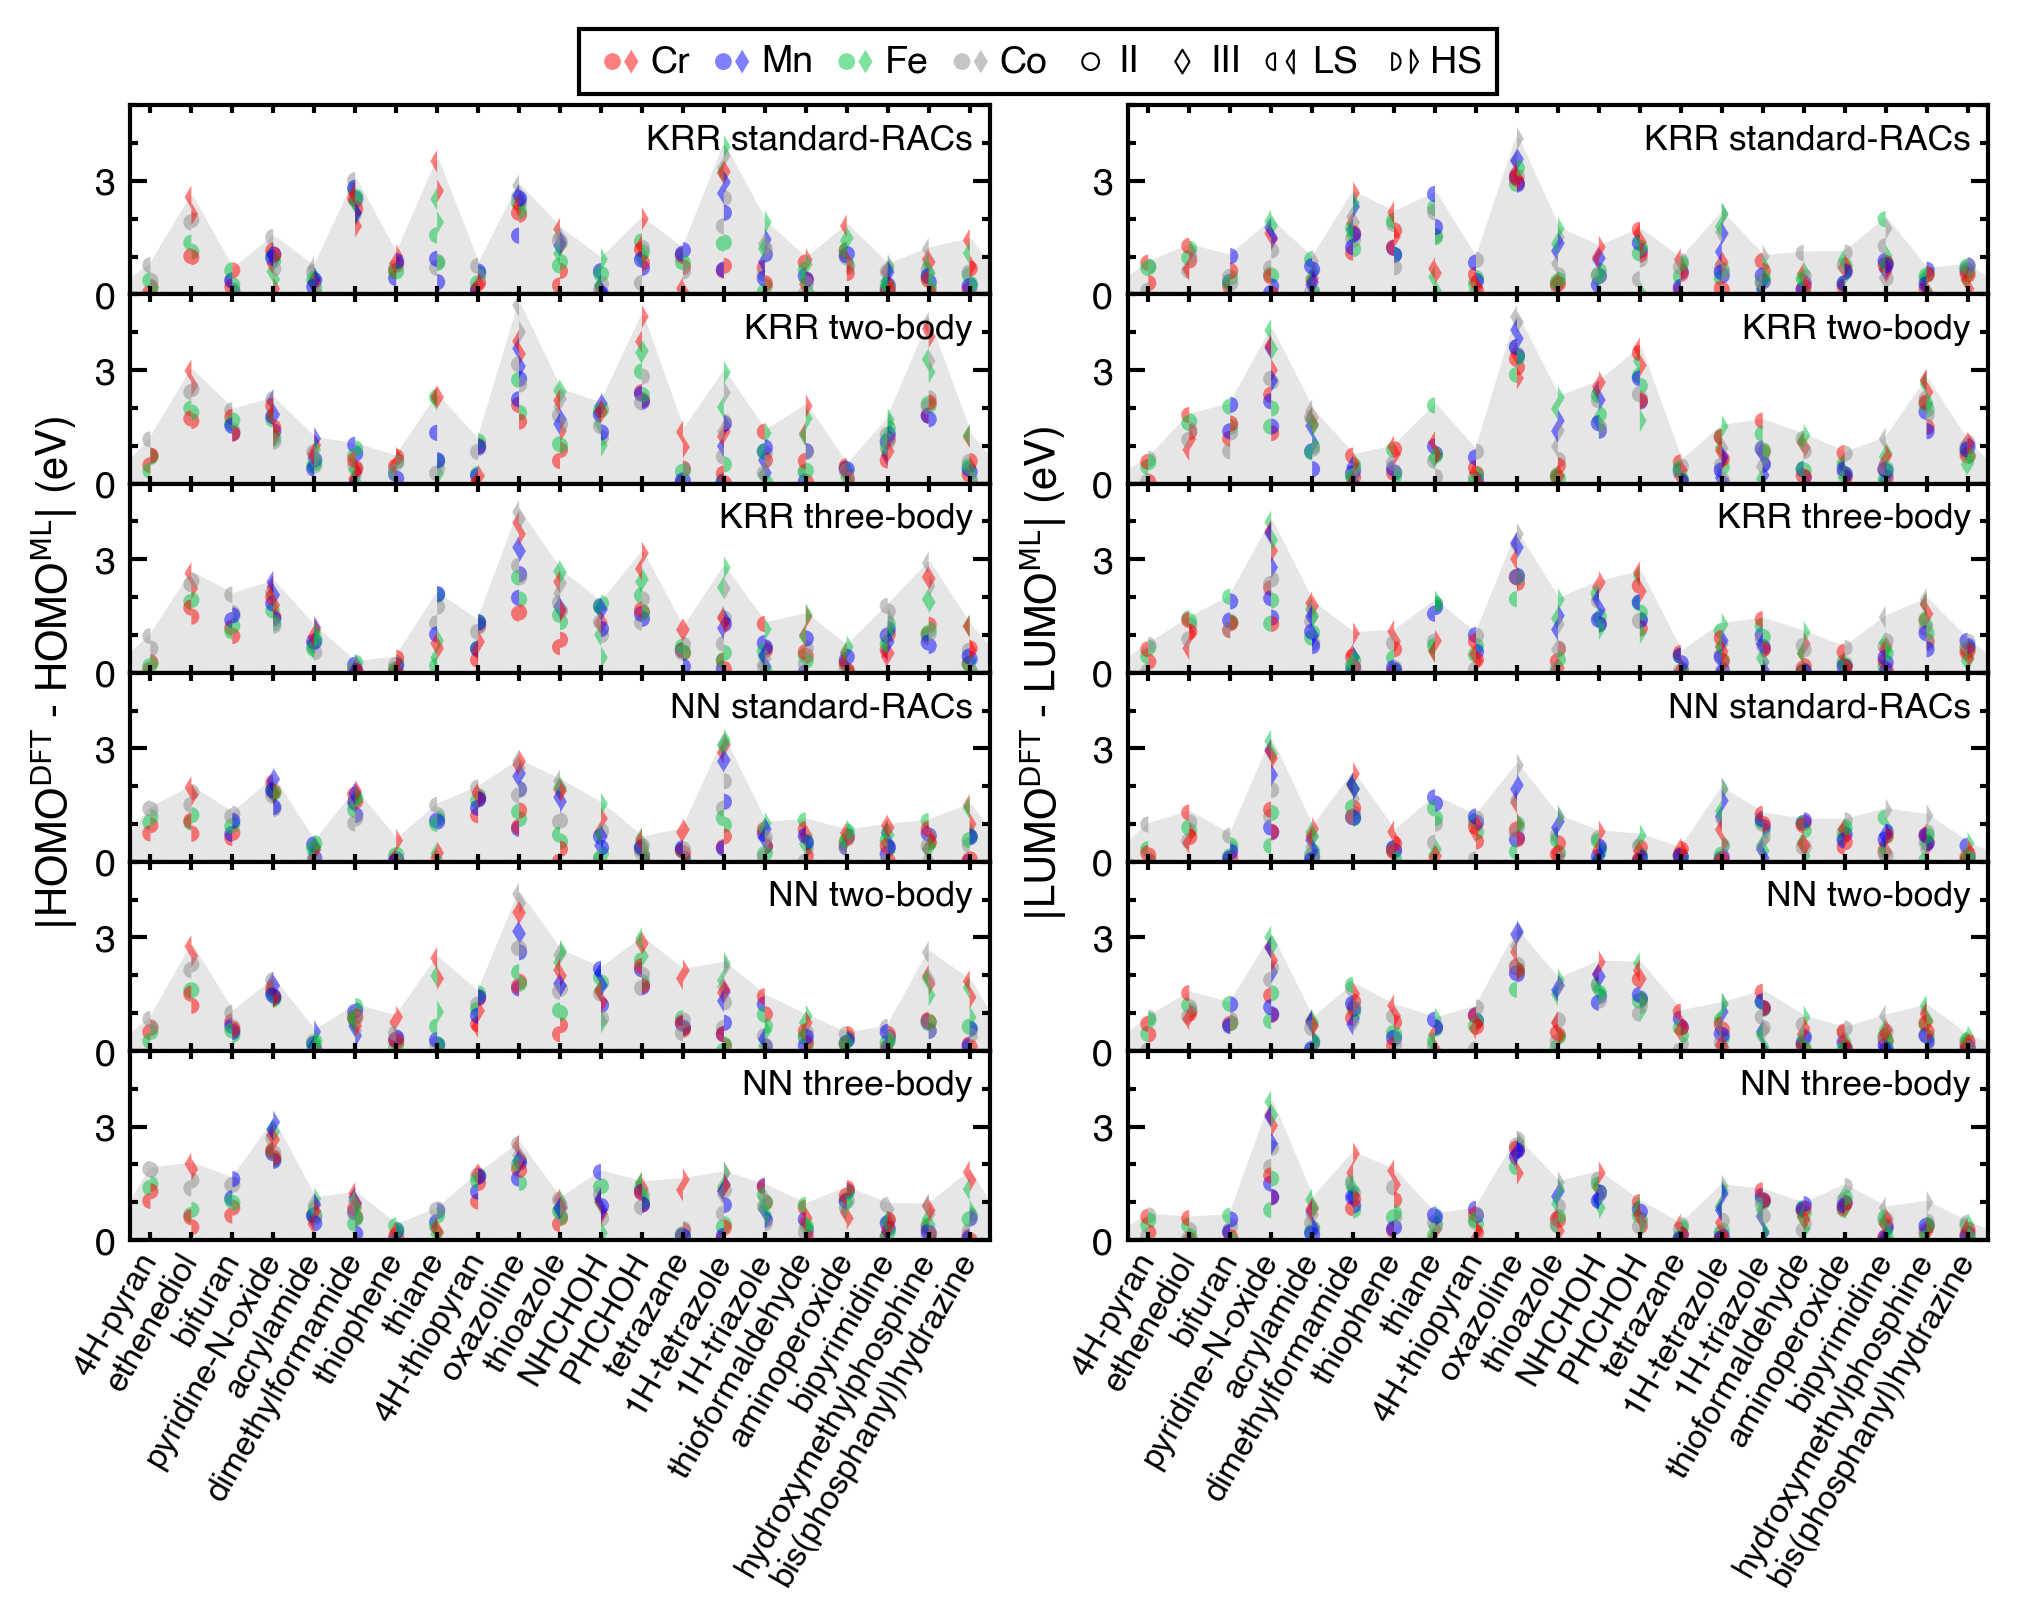

In [11]:
_, y = data_prep(
    df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.ORBITALS, False
)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
ligands = df_lig_test["name"].str.split("_", expand=True)[2]

fill_between = True
colors = np.array([color_dict[core[:2]] for core in cores])
markers_left = np.array(
    [MarkerStyle(marker_dict[core[-1]], fillstyle="left") for core in cores]
)
markers_right = np.array(
    [MarkerStyle(marker_dict[core[-1]], fillstyle="right") for core in cores]
)
# Sort the results by the ligands
plot_x = np.argmax(ligands.values[:, np.newaxis] == test_ligands, axis=1)

figsize = (6.66, 1.6 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.06,
    "right": 0.99,
    "top": 0.94,
    "bottom": 0.23,
    "hspace": 0.0,
    "wspace": 0.16,
}
axes = fig.subplots(
    ncols=2,
    nrows=6,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 15, "alpha": 0.5, "edgecolors": "none"}
lower_lim = 0.0
upper_lim = 5.0

for experiment, (ax0, ax1) in zip(experiments, axes):
    for ind, ax, markers in [
        (0, ax0, markers_left),
        (1, ax0, markers_right),
        (2, ax1, markers_left),
        (3, ax1, markers_right),
    ]:
        scatter_random_z(
            ax,
            plot_x,
            abs(experiment.prediction[:, ind] - y[:, ind]),
            colors,
            markers,
            **scatter_kwargs,
        )

    for ax in [ax0, ax1]:
        ax.set_xticks(np.arange(21))
        ax.set_xticklabels(
            [ligand_names[name] for name in test_ligands],
            rotation=60,
            ha="right",
            va="center",
            rotation_mode="anchor",
            fontsize=8,
        )
        ax.text(
            0.98,
            0.9,
            model_names[experiment.name],
            ha="right",
            va="top",
            fontsize=8.5,
            transform=ax.transAxes,
        )
        ax.axhline(0, color="0.5", linestyle=":", zorder=0.5)
        ax.tick_params(length=2, axis="x")
    ax0.set_xlim(-0.5, 20.5)
    ax0.set_ylim(lower_lim, upper_lim)
    ax0.yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax0.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax1.yaxis.set_tick_params(which="both", labelleft=True)

    if fill_between:
        for ax, indices in [(ax0, [0, 1]), (ax1, [2, 3])]:
            # This vector is 2 entries longer than the number of ligands to enable
            # "tappering off" at the ends
            x_vec = np.arange(-1, len(test_ligands) + 1)
            y_upper = np.zeros(len(x_vec))
            y_lower = np.zeros(len(x_vec))
            for i in range(len(test_ligands)):
                deviations = abs(experiment.prediction[:, indices] - y[:, indices])[
                    plot_x == i
                ]
                y_upper[i + 1] = max(0, deviations.max())
            ax.fill_between(x_vec, y_upper, y_lower, color="0.9", zorder=0.0)

fig.text(
    0.01,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$|$HOMO$^\mathrm{DFT}$ - HOMO$^\mathrm{ML}|$ (eV)",
    rotation=90,
    va="center",
)
fig.text(
    0.505,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$|$LUMO$^\mathrm{DFT}$ - LUMO$^\mathrm{ML}|$ (eV)",
    rotation=90,
    va="center",
)

# Legend
core_legend(
    axes[0, 0],
    legend_kwargs=dict(
        loc="upper left",
        bbox_to_anchor=[0.5, 1.5],
        markerscale=0.9,
        handletextpad=0.0,
        columnspacing=0.4,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=-0.5)},
    ),
)

fig.savefig("plots/error_plot_homo_lig_test.pdf")

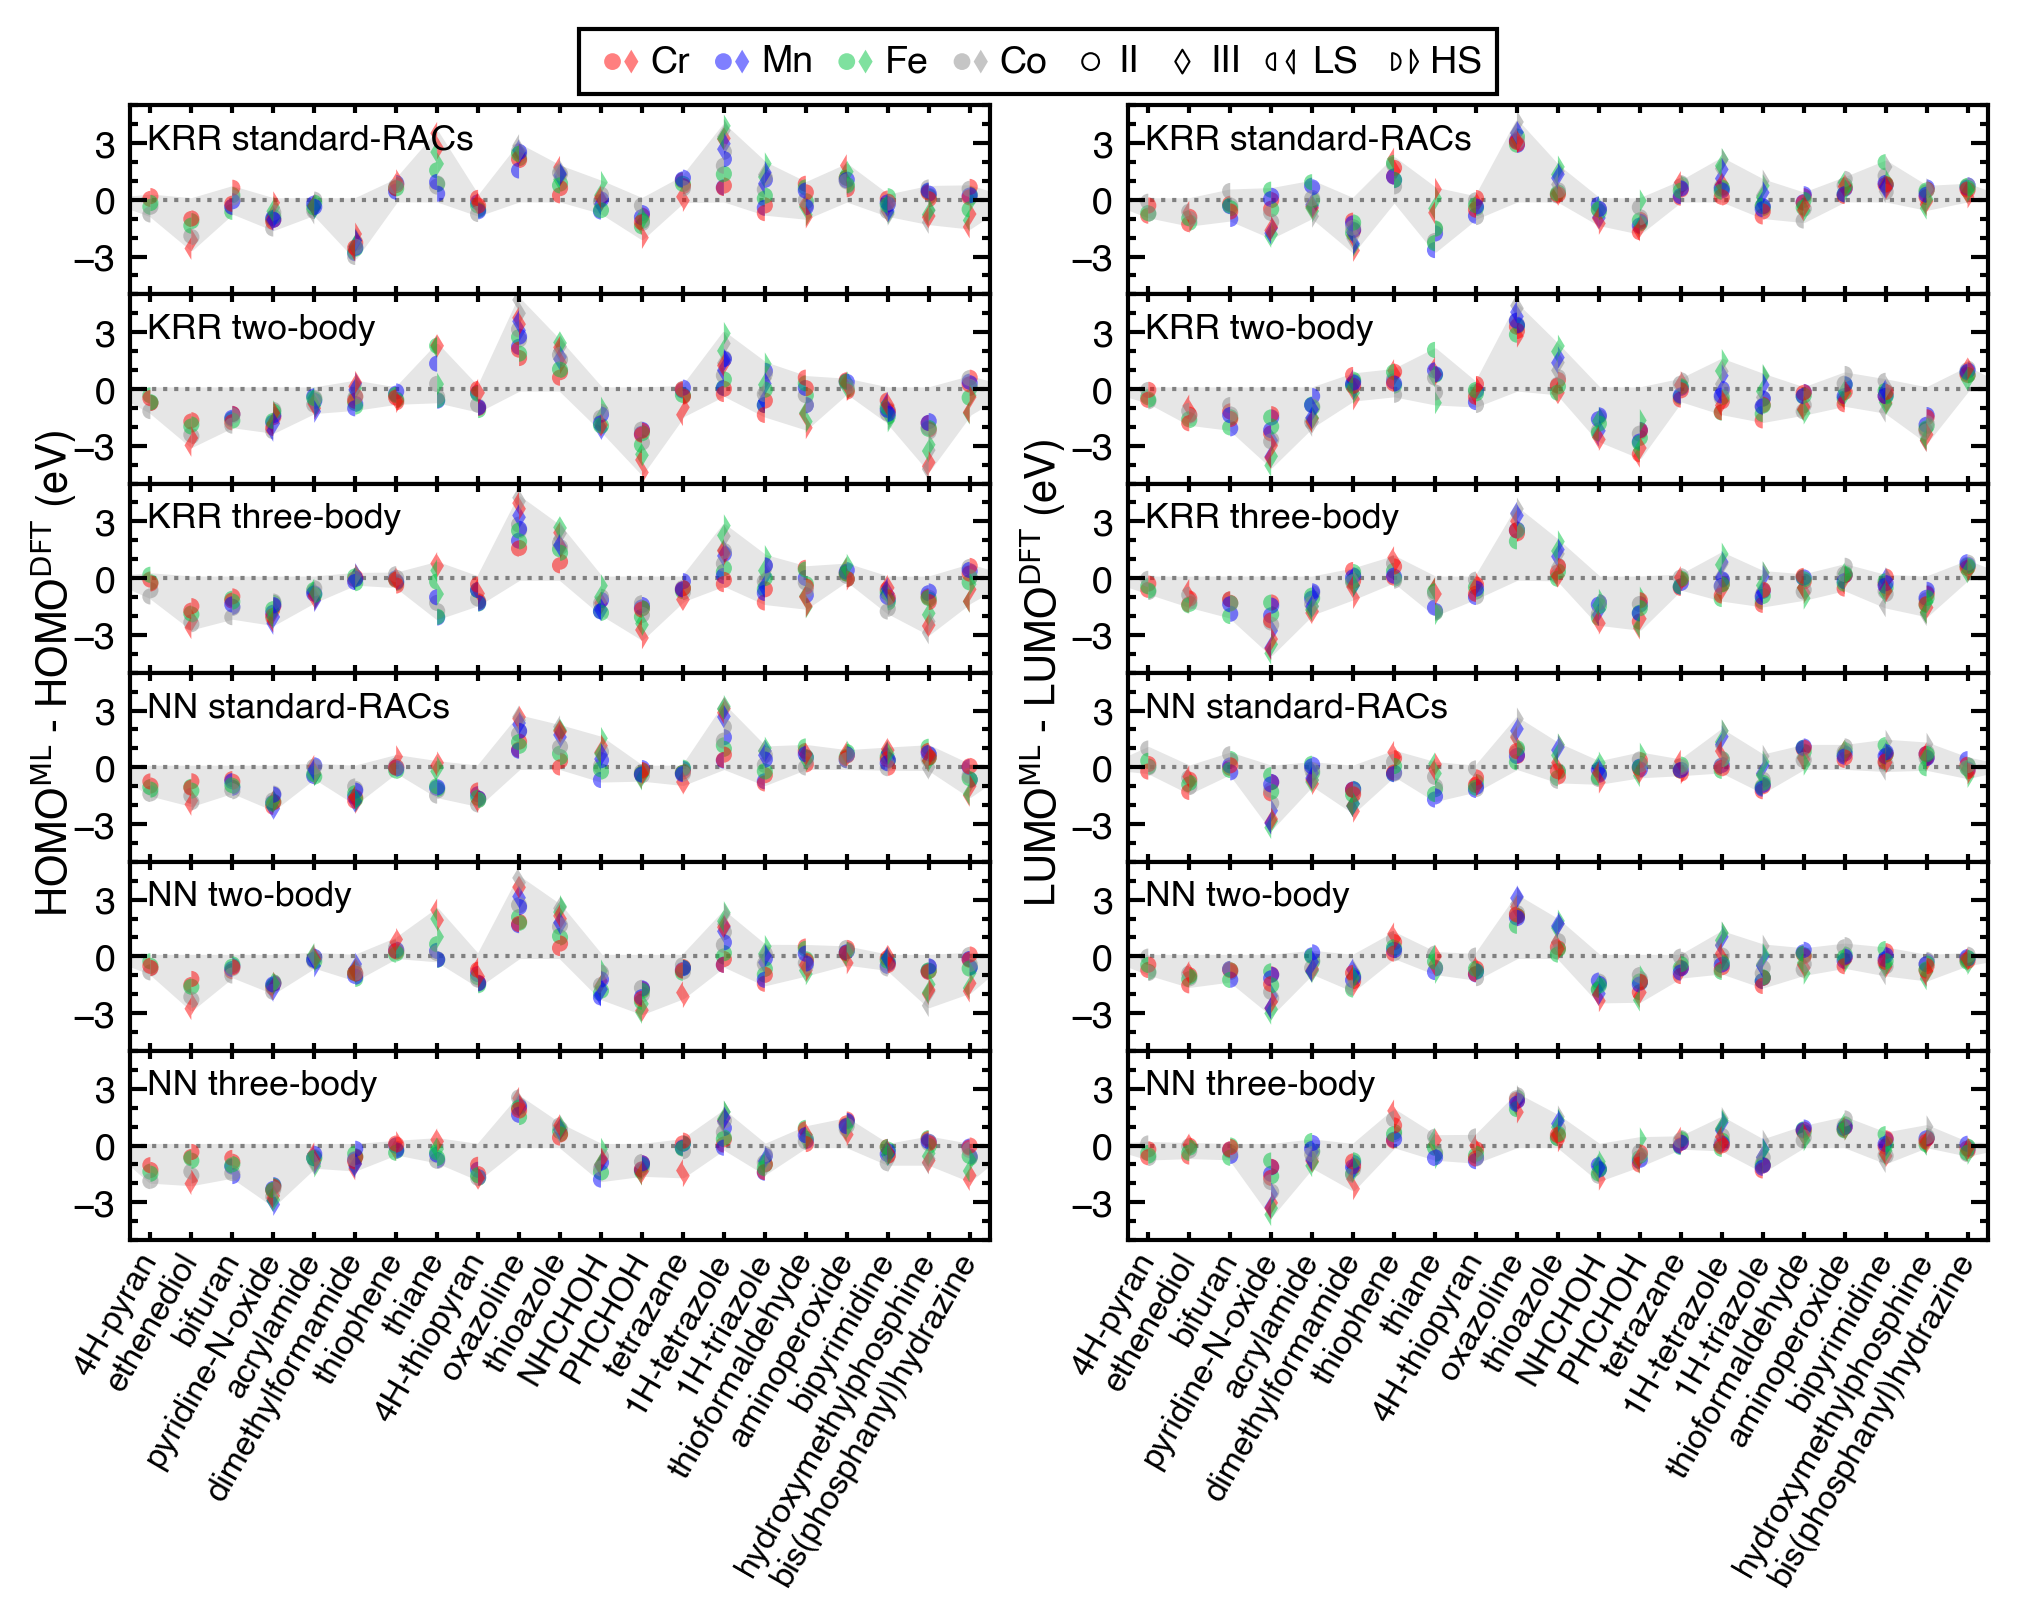

In [12]:
_, y = data_prep(
    df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.ORBITALS, False
)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
ligands = df_lig_test["name"].str.split("_", expand=True)[2]

fill_between = True
colors = np.array([color_dict[core[:2]] for core in cores])
markers_left = np.array(
    [MarkerStyle(marker_dict[core[-1]], fillstyle="left") for core in cores]
)
markers_right = np.array(
    [MarkerStyle(marker_dict[core[-1]], fillstyle="right") for core in cores]
)
# Sort the results by the ligands
plot_x = np.argmax(ligands.values[:, np.newaxis] == test_ligands, axis=1)

figsize = (6.66, 1.6 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.06,
    "right": 0.99,
    "top": 0.94,
    "bottom": 0.23,
    "hspace": 0.0,
    "wspace": 0.16,
}
axes = fig.subplots(
    ncols=2,
    nrows=6,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 15, "alpha": 0.5, "edgecolors": "none"}
lower_lim = -5.0
upper_lim = 5.0

for experiment, (ax0, ax1) in zip(experiments, axes):
    for ind, ax, markers in [
        (0, ax0, markers_left),
        (1, ax0, markers_right),
        (2, ax1, markers_left),
        (3, ax1, markers_right),
    ]:
        scatter_random_z(
            ax,
            plot_x,
            experiment.prediction[:, ind] - y[:, ind],
            colors,
            markers,
            **scatter_kwargs,
        )

    for ax in [ax0, ax1]:
        ax.set_xticks(np.arange(21))
        ax.set_xticklabels(
            [ligand_names[name] for name in test_ligands],
            rotation=60,
            ha="right",
            va="center",
            rotation_mode="anchor",
            fontsize=8,
        )
        ax.text(
            0.02,
            0.9,
            model_names[experiment.name],
            ha="left",
            va="top",
            fontsize=8.5,
            transform=ax.transAxes,
        )
        ax.axhline(0, color="0.5", linestyle=":", zorder=0.5)
        ax.tick_params(length=2, axis="x")
    ax0.set_xlim(-0.5, 20.5)
    ax0.set_ylim(lower_lim, upper_lim)
    ax0.yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax0.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax1.yaxis.set_tick_params(which="both", labelleft=True)

    if fill_between:
        for ax, indices in [(ax0, [0, 1]), (ax1, [2, 3])]:
            # This vector is 2 entries longer than the number of ligands to enable
            # "tappering off" at the ends
            x_vec = np.arange(-1, len(test_ligands) + 1)
            y_upper = np.zeros(len(x_vec))
            y_lower = np.zeros(len(x_vec))
            for i in range(len(test_ligands)):
                deviations = (experiment.prediction[:, indices] - y[:, indices])[
                    plot_x == i
                ]
                y_upper[i + 1] = max(0, deviations.max())
                y_lower[i + 1] = min(0, deviations.min())
            ax.fill_between(x_vec, y_upper, y_lower, color="0.9", zorder=0.0)

fig.text(
    0.01,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "HOMO$^\mathrm{ML}$ - HOMO$^\mathrm{DFT}$ (eV)",
    rotation=90,
    va="center",
)
fig.text(
    0.505,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "LUMO$^\mathrm{ML}$ - LUMO$^\mathrm{DFT}$ (eV)",
    rotation=90,
    va="center",
)

# Legend
core_legend(
    axes[0, 0],
    legend_kwargs=dict(
        loc="upper left",
        bbox_to_anchor=[0.5, 1.5],
        markerscale=0.9,
        handletextpad=0.0,
        columnspacing=0.4,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=-0.5)},
    ),
)

fig.savefig("plots/error_plot_homo_lig_test_alt.pdf")